In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from dataclasses import dataclass
from typing import Sequence, Hashable, TypeVar, Generic, Container, Any, Union, Counter
from collections import namedtuple
from itertools import product
import random
from random import Random
from collections import defaultdict, Counter
import gymnasium as gym

import matplotlib.pyplot as plt
from matplotlib import patheffects


## MDP Class

In [2]:
# We want actions to be hashable so that we can use them as dictionary keys for Q-learning later
Action = TypeVar('Action', bound=Hashable)
State = TypeVar('State', bound=Hashable)

@dataclass(frozen=True, eq=True, repr=True)
class Step:
    '''For keeping track of trajectories'''
    state : State
    action : Action
    reward : float
    next_state : State

Trajectory = Sequence[Step]

class MarkovDecisionProcess(Generic[State, Action]):
    '''A general class for many MDPs.'''
    discount_rate : float
    action_space : Sequence[Action]
    state_space : Sequence[State]
    state_action_space : Sequence[tuple[State, Action]]

    def actions(self, s : State) -> Sequence[Action]:
        '''Return the action space.'''
        return self.action_space
    
    def next_state_sample(self, s : State, a : Action, rng : Random = random) -> State:
        '''Sample the next state.'''
        raise NotImplementedError
    
    def reward(self, s : State, a : Action, ns : State) -> float:
        raise NotImplementedError
    
    def is_absorbing(self, s : State) -> bool:
        raise NotImplementedError




## Shape World Class

In [3]:

Shape = namedtuple('Shape',['sides', 'shade', 'texture'])
State = namedtuple('State',['shape1', 'shape2', 'shape3'])
Action = namedtuple('Action',['actor','recipient'])

# The action space. a = actor, r = recipient
a1r2 = Action(0, 1)
a1r3 = Action(0, 2)
a2r1 = Action(1, 0)
a2r3 = Action(1, 2)
a3r1 = Action(2, 0)
a3r2 = Action(2, 1)

class ShapeWorld(MarkovDecisionProcess[State, Action]):
    GOAL = None
    GOAL_REWARD = 0 # we let this be zero because of averaging across Q-tables we do later
    STEP_COST = -1
    SHAPE_LIST = tuple(['circle','square','triangle'])
    SHADE_LIST = tuple(['low','medium','high'])
    TEXTURE_LIST = tuple(['present','not_present'])
    SHAPE_TRANSITION_PROB = 0.8

    def __init__(self, goal : State, discount_rate):
        self.discount_rate = discount_rate
        self.GOAL = goal

        # set up shapeworld shape space
        shape_space : Sequence[Shape] = tuple(
            Shape(sides, shade, texture) 
                for (sides, shade, texture) 
                    in product(self.SHAPE_LIST,self.SHADE_LIST,self.TEXTURE_LIST)
        )

        # set up state space
        self.state_space : Sequence[State] = tuple(
            State(shape1, shape2, shape3) for(shape1, shape2, shape3) in product(shape_space, shape_space, shape_space)
        )

        # set up state action space
        self.action_space = tuple([a1r2, a1r3, a2r1, a2r3, a3r1, a3r2])
        self.state_action_space = tuple(product(self.state_space, self.action_space))

    def actions(self, s : State) -> Sequence[Action]:
        '''Return the action space.'''
        return self.action_space
    
    def next_state_sample(
            self,
            s : State,
            a : Action,
            rng : random.Random = random
    ) -> State:
        # determine if recipient shape changes
        if rng.random() < self.SHAPE_TRANSITION_PROB:
            sides = s[a.actor].sides
        else:
            sides = s[a.recipient].sides
        
        # determine if the recipient shade changes
        shade = None

        if self._is_darker(s[a.actor].shade, s[a.recipient].shade):
            shade = self._get_darker_shade(s[a.recipient].shade)

        elif self._is_lighter(s[a.actor].shade, s[a.recipient].shade):
            shade = self._get_lighter_shade(s[a.recipient].shade)

        else:
            shade = s[a.recipient].shade

        # determine recipient texture change
        texture = 'not_present' if s[a.recipient].texture == 'present' else 'present'

        # instantiate next state
        new_state_list  = [s[0], s[1], s[2]]
        new_state_list[a.recipient] = Shape(sides, shade, texture)
        new_state = tuple(new_state_list)

        return new_state
    
    def reward(self, s: State, a : Action, ns : State) -> float:
        reward = self.STEP_COST
        if self._is_goal(ns):
            reward += self.GOAL_REWARD
        return reward

    def is_absorbing(self, s: State) -> bool:
        '''
        Check to see if state is absorbing. 

        For this conetext, the goal state is our absorbing state, and the simulation should be terminated if reached.

        Returns:
            bool: Whether the state is an absorbing state or not.
        '''
        is_absorbing = np.nan
        if self.GOAL == s:
            is_absorbing = True
        else:
            is_absorbing = False
        
        return is_absorbing

    def plot(self, ax=None):
        raise NotImplementedError
    
    # helper functions
    def _is_goal(self, ns : State):
        return self.GOAL == ns

    def _is_darker(self, shade1, shade2):
        return self.SHADE_LIST.index(shade1) > self.SHADE_LIST.index(shade2)
    
    def _is_lighter(self, shade1, shade2):
        return self.SHADE_LIST.index(shade1) < self.SHADE_LIST.index(shade2)
    
    def _get_darker_shade(self, shade):
        current_idx = self.SHADE_LIST.index(shade)
        return self.SHADE_LIST[current_idx + 1] if current_idx > 0 else shade
    
    def _get_lighter_shade(self, shade):
        current_idx = self.SHADE_LIST.index(shade)
        return self.SHADE_LIST[current_idx - 1] if current_idx < len(self.SHADE_LIST) else shade



In [4]:
# Test the above code

# Make shape world
shape1 = Shape(sides='circle', shade='medium', texture='present')
shape2 = Shape(sides='square', shade='low', texture='present')
goal = State(shape2, shape1, shape1)
shape_world = ShapeWorld(goal, discount_rate=0.8)

# Test the transition function
shapeA = Shape(sides='circle', shade='medium', texture='present')
shapeB = Shape(sides='square', shade='low', texture='present')
s0 = State(shapeA, shapeA, shapeA)
s0

# Check out the state space
#shape_world.state_space

State(shape1=Shape(sides='circle', shade='medium', texture='present'), shape2=Shape(sides='circle', shade='medium', texture='present'), shape3=Shape(sides='circle', shade='medium', texture='present'))

## Agents

In [5]:
# We want actions to be hashable so that we can use them as dictionary keys for Q-learning later
Action = TypeVar('Action', bound=Hashable)
State = TypeVar('State', bound=Hashable)

class MDPPolicy(Generic[State, Action]):
    '''A very general class for an MDP policy.'''
    DISCOUNT_RATE : float

    def action_sample(self, s : State, rng : Random = random) -> Action:
        '''Sample which actions to take.'''
        raise NotImplementedError
    
    def state_value(self, s : State) -> float:
        '''Retrieve the value of a state: s.'''
        raise NotImplementedError
    
    def update(self, s : State, a : Action, r : float, ns : State) -> None:
        '''Update the value of a state action pair.'''
        raise NotImplementedError
    
    def end_episode(self) -> None:
        raise NotImplementedError
    
    def reset(self) -> None:
        raise NotImplementedError

class BaseLearner(MDPPolicy):
    def __init__(self, discount_rate, learning_rate, initial_value, epsilon, action_space):
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.initial_value = initial_value
        self.epsilon = epsilon
        self.action_space = action_space

    def reset(self):
        '''
        Using default dict allows us to set a default value for 
        items that do not have a value assigned to them yet. 
        Useful for updating values for state-action pairs for states
        that have not been encountered yet. 
        '''
        self.estimated_state_action_values = defaultdict(
            lambda : {a: self.initial_value for a in self.action_space}
        )

    def state_value(self, s) -> float:
        return max(self.estimated_state_action_values[s].values())
    
    def action_sample(self, s, rng = random):
        # e-greedy action selection
        if rng.random() < self.epsilon:
            return rng.choice(self.action_space)
        astar = max(self.estimated_state_action_values[s].items(),
                          key = lambda x: x[1])[0]
        return astar
    
    def end_episode(self) -> None:
        raise NotImplementedError

class QLearner(MDPPolicy):
    def end_episode(self):
        pass

    def update(self, s, a, r, ns):

        # TODO: will this ever update the actual goal state value?
        max_ns_q = max(self.estimated_state_action_values[ns].values())
        td_target = r + self.discount_rate * max_ns_q
        td_error = td_target - self.estimated_state_action_values[s][a]
        self.estimated_state_action_values[s][a] += self.learning_rate * td_error




        
    




## Simulation, Gym, and Plotting

In [6]:
ObsType = Union[int, np.ndarray, dict[str, Any]]
ActType = Union[int, np.ndarray, dict[str, Any]]

class GymWrapper(gym.Env):
    '''
    A convenient class for creating an environment for performing simulations. 
    '''
    def __init__(self, mdp : MarkovDecisionProcess):
        self.mdp = mdp
        self.current_state = None
        self.rng : random.Random = random
        self.action_space = gym.spaces.Discrete(len(mdp.action_space))
        assert not isinstance(next(iter(mdp.action_space)), int), \
            "To avoid ambiguity with gym action encoding, action space must not be an integer"
        self.observation_space = gym.spaces.Discrete(len(mdp.state_space))
        self.reward_range = (float('-inf'), float('inf'))

    def step(self, action : ActType) -> tuple[ObsType, float, bool, dict[str, Any]]:
        '''
        Returns: 
            obs, reward, terminated, info
        '''
        assert isinstance(action, int), 'Input is the action index'
        action = self.mdp.action_space[action]
        next_state = self.mdp.next_state_sample(self.current_state, action, rng=self.rng)
        next_state_idx = self.mdp.state_space.index(next_state)
        reward = self.mdp.reward(self.current_state, action, next_state)
        terminated = self.mdp.is_absorbing(next_state)
        self.current_state = next_state
        info = dict(
            state=self.current_state,
            action=action,
            next_state=next_state,
            reward=reward
        )
        return next_state_idx, reward, terminated, info
    
    def reset(self, *, seed : int = None, options : dict[str, Any] = None) -> tuple[ObsType, dict[str, Any]]:
        '''
        Resets the starting state for when starting another episode.
        '''
        super().reset(seed=seed)
        self.rng = random.Random(seed)
        # TODO: fix this to where the starts really are random
        '''
        shape1 = Shape(sides='circle', shade='medium', texture='present')
        shape2 = Shape(sides='square', shade='low', texture='present')
        shape3 = Shape(sides='triangle', shade='high', texture='present')
        '''
        
        # using this starting state to make sure that it's easy to achieve the goal
        shape1 = Shape(sides='circle', shade='medium', texture='not_present')

        s0 = State(shape1, shape1, shape1)
        self.current_state = s0 #self.mdp.initial_state_dist().sample(rng=self.rng)
        return self.mdp.state_space.index(self.current_state), dict(state=self.current_state)
    
    def render(self) -> None:
        raise NotImplementedError

In [7]:
class TDLearningSimulationResult:
    def __init__(
            self,
            trajectory,
            state_values,
            policy : MDPPolicy,
            sw : ShapeWorld
    ):
        self.trajectory = trajectory
        self.state_values = state_values
        self.policy = policy
        self.sw = sw # shape world

    def plot_timestep(self, timestep):
        raise NotImplementedError
        # TODO: Create plotting code to visualize what the learner is doing.
        timestep = timestep if timestep >= 0 else len(self.trajectory) + timestep
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        states_visited = Counter(
            [s for s, _, _, _, _ in self.trajectory[:timestep]]
        )
        gwp = self.sw.plot(ax=axes[0])
        gwp.plot_location_map(states_visited)
        gwp.ax.set_title(f"States Visitation Counts at Timestep {timestep}")
        gwp = self.sw.plot(ax=axes[1])
        gwp.plot_location_map(self.state_values[timestep])
        gwp.ax.set_title(f"State Values at Timestep {timestep}")

    def rewards(self):
        '''
        Get the rewards at each time step. Recall that trajectory has format:
        trajectory.append((state, action, reward, new_state, done))
        '''
        return np.array([r for _, _, r, _, _ in self.trajectory])

    def plot_reward_rate(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=200)
        _ = ax.plot(self.rewards().cumsum() / np.arange(1, len(self.rewards()) + 1))
        ax.set_title("Reward Rate")
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Reward Rate")

    

In [8]:
def simulation_loop(
        *,
        env: GymWrapper,
        policy : MDPPolicy,
        n_episodes : int,
        max_steps : int,
        seed: int,
) -> TDLearningSimulationResult:
    '''
    Runs a RL simulation and conveniently stores the results.

    Returns:
        TDLearningSimulationResult
    '''
    
    # both initialize and reset the Q values
    policy.reset()
    trajectory = []
    state_values = []
    rng = random.Random(seed)

    # episodes loop
    for _ in tqdm(range(n_episodes), desc="Episodes"):
        # TODO: finish implementing the reset function
        state_idx, _ = env.reset(seed=rng.randint(0, 2**32 - 1))
        state = env.mdp.state_space[state_idx]

        # steps loop
        for _ in range(max_steps):
            action = policy.action_sample(state, rng=rng)
            action_idx = env.mdp.action_space.index(action)
            new_state_idx, reward, done, _ = env.step(action_idx)
            new_state = env.mdp.state_space[new_state_idx]
            policy.update(
                s=state,
                a=action,
                r=reward,
                ns=new_state
            )

            trajectory.append((state, action, reward, new_state, done))
            state_values.append({
                s: policy.state_value(s)
                for s in env.mdp.state_space
            })

            # if we reach the termination condition (an absorbing state), simulation is done. 
            if done:
                break
            state = new_state
        policy.end_episode()
    return TDLearningSimulationResult(trajectory, state_values, policy, env.mdp)

## Initializing Q-Learning Agent

In [10]:
# Make Shape World + Environment/Gym
# Make shape world and set the goal state
shape1 = Shape(sides='circle', shade='medium', texture='present')
shape2 = Shape(sides='square', shade='low', texture='present')
goal = State(shape1, shape1, shape1)
shape_world = ShapeWorld(goal=goal, discount_rate=0.8)
shape_world

shape_env = GymWrapper(shape_world)

# Make a Q-Learner
qlearner = QLearner(
    discount_rate = shape_world.discount_rate,
    learning_rate = 0.1,
    initial_value=0,
    epsilon=0.2,
    # TODO: Why does other code use mdp.action_space?
    action_space=shape_world.action_space
)

# Specify the simulation parameters
results = simulation_loop(
    env = shape_env,
    policy = qlearner,
    n_episodes=100,
    max_steps=1000,
    seed = None
)



Episodes: 100%|██████████| 100/100 [00:00<00:00, 230.99it/s]


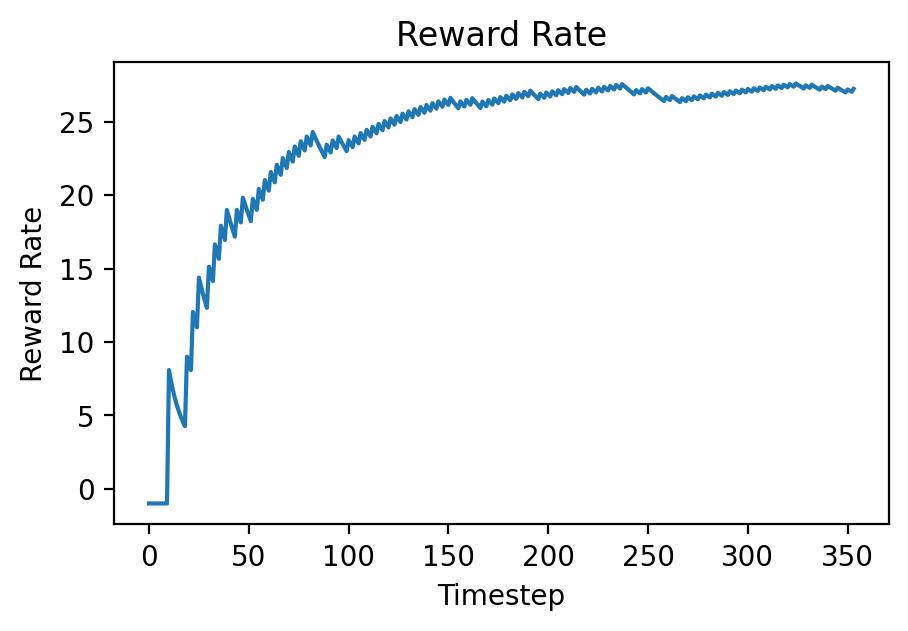

In [11]:
# Plot the results
results.plot_reward_rate()

In [22]:
results.rewards().cumsum() / np.arange(1, len(results.rewards()) + 1)


array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 99, -1, -1, -1, -1, -1, -1,
       -1, -1, 99, -1, -1, 99, -1, -1, 99, -1, -1, -1, -1, 99, -1, -1, 99,
       -1, -1, 99, -1, -1, 99, -1, -1, -1, -1, 99, -1, -1, 99, -1, -1, -1,
       -1, 99, -1, -1, 99, -1, -1, 99, -1, -1, 99, -1, -1, 99, -1, -1, 99,
       -1, -1, 99, -1, -1, 99, -1, -1, 99, -1, -1, 99, -1, -1, 99, -1, -1,
       -1, -1, -1, -1, 99, -1, -1, 99, -1, -1, 99, -1, -1, -1, -1, 99, -1,
       -1, 99, -1, -1, 99, -1, -1, 99, -1, -1, 99, -1, -1, 99, -1, -1, 99,
       -1, -1, 99, -1, -1, 99, -1, -1, 99, -1, -1, 99, -1, -1, 99, -1, -1,
       99, -1, -1, 99, -1, -1, 99, -1, -1, 99, -1, -1, 99, -1, -1, 99, -1,
       -1, -1, -1, 99, -1, -1, 99, -1, -1, 99, -1, -1, -1, -1, 99, -1, -1,
       99, -1, -1, 99, -1, -1, 99, -1, -1, 99, -1, -1, 99, -1, -1, 99, -1,
       -1, 99, -1, -1, 99, -1, -1, -1, -1, 99, -1, -1, 99, -1, -1, 99, -1,
       -1, 99, -1, -1, 99, -1, -1, 99, -1, -1, 99, -1, -1, -1, -1, 99, -1,
       -1, 99, -1, -1, 99

In [29]:
results.rewards().mean()

27.24858757062147

## Goal Selection Agent Class

In [ ]:
class BaseGoalLearner(MDPPolicy):
    '''
    An agent that uses another agent to plan, and then tries to select good goals.

    Importantly, the action space for goal selection is different - in that participants can select any state at their goal. 
    The MDP is also different than the base shape world, since the starting state transition function is also different. 
    '''

    DEPTH_BUDGET : float
    EPISODE_BUDGET : float

    def __init__(self, 
                 planner_discount_rate, 
                 planner_learning_rate, 
                 planner_initial_value, 
                 planner_epsilon, 
                 planner_action_space, 
                 planner,
                 discount,
                 DEPTH_BUDGET,
                 EPISODE_BUDGET):
        '''
        The planning agent will always be the same, and uses these other parameters. 
        '''
        # for the goal selection agent
        self.discount = discount

        # for the planning agent
        self.planner_discount_rate = planner_discount_rate
        self.planner_learning_rate = planner_learning_rate
        self.planner_initial_value = planner_initial_value
        self.planner_epsilon = planner_epsilon
        self.planner_action_space = planner_action_space
        self.planner = planner # agent to do planning for goal selection

    def plan(self, s : State, a : Action):
        '''
        Update the value of goal states by running agent simulations given the goal state (a) of interest.
        '''

        # instantiate the base mdp and correponding planner
        shape_world = ShapeWorld(goal=a, discount_rate=self.planner_discount_rate) # goal action (a) dictates reward function of MDP
        shape_env = GymWrapper(shape_world)
        qlearner = QLearner(
            discount_rate = shape_world.discount_rate,
            learning_rate = 0.1,
            initial_value=0,
            epsilon=0.2,
            action_space=shape_world.action_space
        )

        # do the planning by running a simulation
        results = simulation_loop(
            env = shape_env,
            policy = qlearner,
            n_episodes=self.EPISODE_BUDGET,
            max_steps=self.DEPTH_BUDGET,
            seed = None
        )

        # get summary statistic of how often goal was achieved to use as value
        goal_value = results.rewards().mean()

        # TODO: I think that multiple states should actually get updated here - reuse of planning!
        # TODO: Reminder that state space for goal planning should be different (and implemented)
        # update the estimated value of the goal

    def action_sample(self, s : State, rng : Random = random) -> Action:
        '''
        Sample which actions to take, this represents which goal to select.
        
        We selection action by also doing planning before hand. 
        '''

        # let's do some planning based off of randomly chosen states
        # TODO: have some other way of choosing what states to plan over
        self.plan()
        
        # e-greedy action selection
        if rng.random() < self.epsilon:
            return rng.choice(self.action_space)
        astar = max(self.estimated_state_action_values[s].items(),
                          key = lambda x: x[1])[0]
        return astar
    
    def state_value(self, s : State) -> float:
        '''Retrieve the value of a state: s.'''
        return max(self.estimated_state_action_values[s].values())
    
    def update(self, s : State, a : Action, r : float, ns : State) -> None:
        '''
        Update the value of a state action pair.

        This is done via planning using another agent. This is where the operations of interest are happening.
        '''

        # update the value of the goal state (a) based on our simulation
        # TODO: make sure that the goal state automatically gets set to the reward
        max_ns_q = max(self.estimated_state_action_values[ns].values())
        td_target = r + self.discount_rate*max_ns_q
        td_error = td_target - self.estimated_state_action_values[s][a]
        self.estimated_state_action_values[s][a] += self.learning_rate * td_error


    
    def end_episode(self) -> None:
        '''
        Nothing special happens for this sort of agent.
        '''
        pass
    
    def reset(self) -> None:
        '''
        Make sure that we reset between simulations. 
        '''
        self.estimated_state_action_values = defaultdict(
            lambda : {a: self.initial_value for a in self.action_space}
        )

In [ ]:
class OptimalGoalPlanner(MDPPolicy):
    '''
    An agent that uses another agent to plan exhaustively over all possible goals.

    The purpose of this planner is actually to compute the optimal value function a priori for goal selection later.
    The planner doesn't do any learning.
    '''

    DEPTH_BUDGET : float
    EPISODE_BUDGET : float

    def __init__(self, planner : MDPPolicy, DEPTH_BUDGET : int, EPISODE_BUDGET : int):
        '''
        When this class is initialized, it needs to compute the value function through planning ahead of time. 
        '''

        self.planner = planner # agent to do planning for goal selection
        self.DEPTH_BUDGET = DEPTH_BUDGET,
        self.EPISODE_BUDGET = EPISODE_BUDGET

    def plan(self):

        # TODO: Put this in a loop to plan for all possible goals, given the starting state.

        # instantiate the base mdp and correponding planner
        shape_world = ShapeWorld(goal=a, discount_rate=self.planner_discount_rate) # goal action (a) dictates reward function of MDP
        shape_env = GymWrapper(shape_world)

        # do the planning by running a simulation
        results = simulation_loop(
            env = shape_env,
            policy = self.planner,
            n_episodes=self.EPISODE_BUDGET,
            max_steps=self.DEPTH_BUDGET,
            seed = None
        )

        # get summary statistic of how often goal was achieved to use as value
        goal_value = results.rewards().mean()

    def action_sample(self, s : State, rng : Random = random) -> Action:
        '''Sample which actions to take.'''
        raise NotImplementedError
    
    def state_value(self, s : State) -> float:
        '''Retrieve the value of a state: s.'''
        raise NotImplementedError
    
    def update(self, s : State, a : Action, r : float, ns : State) -> None:
        '''This planner doesn't learn after planning.'''
        pass
    
    def end_episode(self) -> None:
        '''
        Nothing needs to happen here at the end of an episode.
        '''
        pass
    
    def reset(self) -> None:
        raise NotImplementedError

    